In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from lightgbm import LGBMClassifier, plot_importance
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("data/transactions.csv")
df.head()

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,ship_cost,coupon_id,coupon_discount,promotion_name,promotion_award_value,is_wallet_trx,is_saved_card_trx,is_returned
0,2021-05-01 00:00:01.761000+00:00,3941815,0,4662,901280147,595758968,95503167,159147197,79.90,51.94,8.88,NaN,0.0,Sepette %35 İndirim,35.0,0,True,0.0
1,2021-05-01 00:00:01.761000+00:00,3941815,0,163,901280149,595758968,36313798,64622938,129.95,59.97,9.40,NaN,0.0,Sepette %40 İndirim,40.0,0,True,0.0
2,2021-05-01 00:00:01.761000+00:00,3941815,0,157306,901280145,595758968,36888320,65612791,59.99,49.99,10.67,NaN,0.0,NaN,NaN,0,True,0.0
3,2021-05-01 00:00:01.761000+00:00,3941815,0,163856,901280144,595758968,36888399,65613254,49.90,49.90,10.67,NaN,0.0,NaN,NaN,0,True,0.0
4,2021-05-01 00:00:02.742000+00:00,15996105,1,968,901279297,595758987,96930601,161408176,89.99,71.99,9.40,NaN,0.0,Sepette %20 İndirim,20.0,0,False,0.0


In [3]:
df.shape

(11193677, 18)

In [4]:
sub_data = pd.read_csv("data/test_data.csv")
sub_data
#id: user_id | product_content_id | order_parent_id

,id,expected
0,18115|87073974|726348863,NaN
1,27588|118753298|723169934,NaN
2,29165|35699988|724122443,NaN
3,29969|5893187|722342150,NaN
4,35107|93897418|723421057,NaN
...,...,...
7466,71083899|100019570|728638514,NaN
7467,71106534|35624085|725372928,NaN
7468,71115350|94438742|725291348,NaN
7469,71115350|100017676|725291348,NaN


In [5]:
df_train = pd.read_csv("train_all.csv")
df_train.head()

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,brand_name,category_id,category_name
0,2021-05-01 00:00:01.761000+00:00,3941815,0,4662,901280147,595758968,95503167,159147197,79.90,51.94,...,25,0.328947,0.003045,3.25000,1,5,682,Slazenger,604,T-Shirt
1,2021-05-01 00:00:01.761000+00:00,3941815,0,157306,901280145,595758968,36888320,65612791,59.99,49.99,...,7,0.777778,0.000744,0.00000,0,0,381,Ltb,2949,Polo Yaka T-shirt
2,2021-05-01 00:00:01.761000+00:00,3941815,0,163856,901280144,595758968,36888399,65613254,49.90,49.90,...,3,0.200000,0.000633,0.00000,0,0,381,Ltb,2949,Polo Yaka T-shirt
3,2021-05-01 00:00:01.761000+00:00,3941815,0,163,901280149,595758968,36313798,64622938,129.95,59.97,...,0,0.000000,0.000545,4.47619,1,5,121,Pierre Cardin,604,T-Shirt
4,2021-05-01 00:00:02.742000+00:00,15996105,1,968,901279297,595758987,96930601,161408176,89.99,71.99,...,0,0.000000,0.002828,4.50000,2,5,40,TRENDYOLMİLLA,1182,Elbise


In [7]:
df_train.shape

(10702717, 31)

In [8]:
train_0 = df_train[df_train.is_returned == 0]
train_1 = df_train[df_train.is_returned == 1]

In [11]:
#numeric olan değerleri z_score a veriyorum
z_score = zscore(train_0[['original_price', 'discounted_price', 'coupon_discount', "returnRate",
   "total_claim", "unresolved_claim", "unresolved_accepted_claim", "unresolvedclaim_percentage",
    "defective_returnRate", "review_rates_mean", "review_rates_min", "review_rates_max"]])

In [14]:
train_0.shape

(9341481, 31)

In [15]:
abs_zscore = abs(z_score)
train_0 = train_0[(abs_zscore < 3).all(axis=1)]

In [16]:
train_0.shape

(7927702, 31)

In [17]:
train_zscore = pd.concat([train_0, train_1])

In [18]:
train_zscore.shape

(9288938, 31)

In [19]:
df = train_zscore.copy()

In [20]:
df["is_saved_card_trx"] = df["is_saved_card_trx"].replace({True: 1, False: 0})

In [21]:
#df["total_discount"] = df["original_price"] - df["discounted_price"]
df["discount_ratio"] = df["discounted_price"] / df["original_price"]
df["discount_with_promotion"] = ((df["coupon_discount"] * -1) + (df["promotion_award_value"])).fillna(0) / 100

In [22]:
df.head()

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,brand_name,category_id,category_name,discount_ratio,discount_with_promotion
0,2021-05-01 00:00:01.761000+00:00,3941815,0,4662,901280147,595758968,95503167,159147197,79.90,51.94,...,0.003045,3.250000,1,5,682,Slazenger,604,T-Shirt,0.650063,0.35
3,2021-05-01 00:00:01.761000+00:00,3941815,0,163,901280149,595758968,36313798,64622938,129.95,59.97,...,0.000545,4.476190,1,5,121,Pierre Cardin,604,T-Shirt,0.461485,0.40
4,2021-05-01 00:00:02.742000+00:00,15996105,1,968,901279297,595758987,96930601,161408176,89.99,71.99,...,0.002828,4.500000,2,5,40,TRENDYOLMİLLA,1182,Elbise,0.799978,0.20
5,2021-05-01 00:00:03.895000+00:00,11914979,1,968,901280115,595759022,80139132,135798900,56.99,28.50,...,0.002828,4.416667,1,5,15508,TRENDYOL MAN,530,Şort & Bermuda,0.500088,0.50
6,2021-05-01 00:00:03.895000+00:00,11914979,1,968,901280114,595759022,82581293,139386629,69.99,28.00,...,0.002828,4.416667,2,5,15508,TRENDYOL MAN,601,Sweatshirt,0.400057,0.60


In [24]:
df.isnull().sum()

order_date                          0
user_id                             0
is_elite_user                       0
supplier_id                         0
order_line_item_id                  0
order_parent_id                     0
product_content_id                  0
product_variant_id                  0
original_price                      0
discounted_price                    0
ship_cost                       23089
coupon_id                     8752738
coupon_discount                     0
promotion_name                4538577
promotion_award_value         4538577
is_wallet_trx                       0
is_saved_card_trx                   0
is_returned                         0
returnRate                          0
total_claim                         0
unresolved_claim                    0
unresolved_accepted_claim           0
unresolvedclaim_percentage          0
defective_returnRate                0
review_rates_mean                   0
review_rates_min                    0
review_rates

In [28]:
df[df["ship_cost"].isnull()]["is_returned"].value_counts()

0.0    23017
1.0       72
Name: is_returned, dtype: int64

In [30]:
drop_cols = ["order_date", "coupon_id", "promotion_name", "discounted_price", "promotion_award_value", "coupon_discount"]

df.drop(drop_cols, axis=1, inplace=True)
df.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,brand_name,category_id,category_name,discount_ratio,discount_with_promotion
0,3941815,0,4662,901280147,595758968,95503167,159147197,79.90,8.880000,0,...,0.003045,3.250000,1,5,682,Slazenger,604,T-Shirt,0.650063,0.35
3,3941815,0,163,901280149,595758968,36313798,64622938,129.95,9.400000,0,...,0.000545,4.476190,1,5,121,Pierre Cardin,604,T-Shirt,0.461485,0.40
4,15996105,1,968,901279297,595758987,96930601,161408176,89.99,9.400000,0,...,0.002828,4.500000,2,5,40,TRENDYOLMİLLA,1182,Elbise,0.799978,0.20
5,11914979,1,968,901280115,595759022,80139132,135798900,56.99,1.342857,0,...,0.002828,4.416667,1,5,15508,TRENDYOL MAN,530,Şort & Bermuda,0.500088,0.50
6,11914979,1,968,901280114,595759022,82581293,139386629,69.99,1.342857,0,...,0.002828,4.416667,2,5,15508,TRENDYOL MAN,601,Sweatshirt,0.400057,0.60


In [31]:
df.shape

(9288938, 27)

In [36]:
df.category_id.nunique()

194

In [39]:
df.groupby("category_name")["is_returned"].sum().sort_values(ascending=False)

category_name
Elbise                     267009.0
T-Shirt                    175890.0
Bluz                       111149.0
Jeans                       90012.0
Pantolon                    88989.0
                             ...   
Tesettür Body                   0.0
Tesettür Tayt                   0.0
Büyük Beden Pijama Üstü         0.0
Hamile Çorabı                   0.0
Fantezi Atlet                   0.0
Name: is_returned, Length: 194, dtype: float64

In [35]:
df.brand_name.nunique()

14041

In [46]:
df.groupby("brand_name")["is_returned"].sum().sort_values(ascending=False)[:20]

brand_name
TRENDYOLMİLLA           596466.0
TRENDYOL MAN             62712.0
DeFacto                  54333.0
Koton                    42545.0
Happiness İst.           31108.0
Penti                    27357.0
Olalook                  21663.0
Mavi                     20500.0
Addax                    19068.0
Trend Alaçatı Stili      17481.0
MANGO Woman              13069.0
armonika                 12484.0
Bershka                  11327.0
ALTINYILDIZ CLASSICS     10331.0
Stradivarius              8687.0
Pull & Bear               8507.0
XENA                      7643.0
Avva                      7327.0
Trendyol Modest           6993.0
Dilvin                    6467.0
Name: is_returned, dtype: float64

In [47]:
drop_cols2 = ["brand_name", "category_name"]

df.drop(drop_cols2, axis=1, inplace=True)
df.shape

(9288938, 25)

In [48]:
df.isnull().sum()

user_id                           0
is_elite_user                     0
supplier_id                       0
order_line_item_id                0
order_parent_id                   0
product_content_id                0
product_variant_id                0
original_price                    0
ship_cost                     23089
is_wallet_trx                     0
is_saved_card_trx                 0
is_returned                       0
returnRate                        0
total_claim                       0
unresolved_claim                  0
unresolved_accepted_claim         0
unresolvedclaim_percentage        0
defective_returnRate              0
review_rates_mean                 0
review_rates_min                  0
review_rates_max                  0
brand_id                          0
category_id                       0
discount_ratio                    2
discount_with_promotion           0
dtype: int64

In [50]:
df[df["discount_ratio"].isnull()]

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,category_id,discount_ratio,discount_with_promotion
4143211,51184114,0,968,983048946,641016985,35793898,163845433,0.0,2.145449,0,...,0,0.0,0.002828,3.142857,1,5,40,563,NaN,0.0
5101449,51184114,0,968,1000157025,650742003,35793898,63929253,0.0,2.659258,0,...,0,0.0,0.002828,3.142857,1,5,40,563,NaN,0.0


In [51]:
df[df["ship_cost"].isnull()]

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,category_id,discount_ratio,discount_with_promotion
467,3503644,0,1188,901286351,595762291,69784098,120923961,69.99,NaN,1,...,443,0.264478,0.000978,4.707071,1,5,3268,563,0.699957,0.0
491,49370370,1,1188,901286392,595762509,40120256,71015608,39.99,NaN,0,...,443,0.264478,0.000978,4.826087,1,5,3268,604,0.699925,0.0
579,12178371,0,163,901289980,595763162,37580808,66810099,199.95,NaN,1,...,0,0.000000,0.000545,3.333333,1,5,121,604,0.299925,0.0
781,4320340,0,968,901291029,595764937,52819965,93957289,69.99,NaN,0,...,0,0.000000,0.002828,4.555556,2,5,40,526,0.342763,0.0
866,5734515,0,1188,901292522,595765613,89711877,149965140,29.99,NaN,0,...,443,0.264478,0.000978,4.509363,1,5,3268,530,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7271939,35250224,0,392,1042200099,674491524,36358502,64730193,10.99,NaN,1,...,103,0.635802,0.000244,4.683502,1,5,14506,550,1.000000,0.0
7271940,35250224,0,392,1042200093,674491524,94181408,156912585,39.90,NaN,1,...,103,0.635802,0.000244,4.692308,4,5,14506,529,0.700000,0.0
7271941,35250224,0,392,1042200097,674491524,113664973,184457651,16.99,NaN,1,...,103,0.635802,0.000244,4.814433,1,5,14506,530,1.000000,0.0
7276179,20031653,1,392,1042257547,674528635,40589510,71932967,19.99,NaN,1,...,103,0.635802,0.000244,4.788462,1,5,14506,598,0.799900,0.0


<AxesSubplot:>

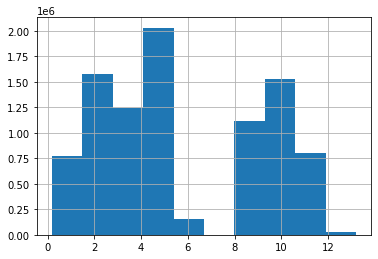

In [52]:
df["ship_cost"].hist()

In [53]:
df["ship_cost"].mean()

5.60984676125739

In [55]:
df["ship_cost"].median()

4.7

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.drop("is_returned", axis=1),
                                                df["is_returned"], test_size=0.2,
                                                  stratify=df["is_returned"], random_state=0)

In [63]:
model = LGBMClassifier(random_state=0)

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [64]:
model.fit(X_train, y_train)

LGBMClassifier(random_state=0)

In [65]:
preds = model.predict(X_val)

In [67]:
print(confusion_matrix(y_val, preds))
print(classification_report(y_val, preds))

[[1571418   14123]
 [ 113064  159183]]
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96   1585541
         1.0       0.92      0.58      0.71    272247

    accuracy                           0.93   1857788
   macro avg       0.93      0.79      0.84   1857788
weighted avg       0.93      0.93      0.92   1857788



<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

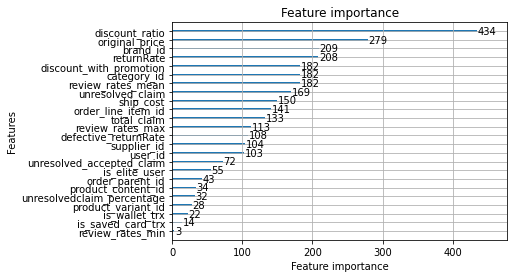

In [68]:
plot_importance(model)

In [69]:
df_test = pd.read_csv("test_all.csv")
df_test.head()

,order_date,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,discounted_price,...,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,brand_name,category_id,category_name
0,2021-07-31 00:00:02.035000+00:00,5323264,0,823,1106635517,721367415,55264030,97997774,649.99,259.96,...,1,0.076923,0.003652,5.000000,5,5,2020,Yargıcı,1182,Elbise
1,2021-07-31 00:00:05.503000+00:00,18238989,1,968,1106636273,721367451,4032918,16332708,104.99,73.49,...,0,0.000000,0.002828,4.378505,1,5,15508,TRENDYOL MAN,604,T-Shirt
2,2021-07-31 00:00:08.173000+00:00,13354100,1,346,1106635244,721367483,98066435,163202748,79.90,39.95,...,0,0.000000,0.001260,4.500000,3,5,381,Ltb,581,Deniz Şortu
3,2021-07-31 00:00:10.850000+00:00,49613268,1,335931,1106634651,721367533,87599480,146668239,119.99,64.99,...,8,0.727273,0.001929,4.071429,1,5,1027526,Meriche,597,Gömlek
4,2021-07-31 00:00:10.989000+00:00,7252871,1,201,1106637202,721367537,96509590,160768055,105.77,59.49,...,47,0.238579,0.002970,3.941176,1,5,36426,Güneşkızı,604,T-Shirt


In [70]:
df_test["is_saved_card_trx"] = df_test["is_saved_card_trx"].replace({True: 1, False: 0})
df_test["discount_ratio"] = df_test["discounted_price"] / df_test["original_price"]
df_test["discount_with_promotion"] = ((df_test["coupon_discount"] * -1) + (df_test["promotion_award_value"])).fillna(0) / 100

In [71]:
df_test.isnull().sum()

order_date                         0
user_id                            0
is_elite_user                      0
supplier_id                        0
order_line_item_id                 0
order_parent_id                    0
product_content_id                 0
product_variant_id                 0
original_price                     0
discounted_price                   0
ship_cost                       1952
coupon_id                     446348
coupon_discount                    0
promotion_name                229894
promotion_award_value         229894
is_wallet_trx                      0
is_saved_card_trx                  0
is_returned                   420819
returnRate                         0
total_claim                        0
unresolved_claim                   0
unresolved_accepted_claim          0
unresolvedclaim_percentage         0
defective_returnRate               0
review_rates_mean                  0
review_rates_min                   0
review_rates_max                   0
b

In [72]:
drop_cols = ["order_date", "coupon_id", "promotion_name", "discounted_price", "promotion_award_value",
             "coupon_discount", "brand_name", "category_name"]

df_test.drop(drop_cols, axis=1, inplace=True)
df_test.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,unresolved_accepted_claim,unresolvedclaim_percentage,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,category_id,discount_ratio,discount_with_promotion
0,5323264,0,823,1106635517,721367415,55264030,97997774,649.99,8.88,0,...,1,0.076923,0.003652,5.000000,5,5,2020,1182,0.399945,0.00
1,18238989,1,968,1106636273,721367451,4032918,16332708,104.99,9.40,1,...,0,0.000000,0.002828,4.378505,1,5,15508,604,0.699971,0.30
2,13354100,1,346,1106635244,721367483,98066435,163202748,79.90,10.67,0,...,0,0.000000,0.001260,4.500000,3,5,381,581,0.500000,0.00
3,49613268,1,335931,1106634651,721367533,87599480,146668239,119.99,11.33,0,...,8,0.727273,0.001929,4.071429,1,5,1027526,597,0.541628,0.40
4,7252871,1,201,1106637202,721367537,96509590,160768055,105.77,8.88,0,...,47,0.238579,0.002970,3.941176,1,5,36426,604,0.562447,0.25


In [77]:
test_preds = model.predict(df_test[X_train.columns])

In [78]:
df_test["id"] = df_test.apply(lambda x: str(x.user_id) + "|" + str(x.product_content_id) + "|" + str(x.order_parent_id), axis=1)

In [79]:
df_test["expected"] = test_preds
df_test.head()

,user_id,is_elite_user,supplier_id,order_line_item_id,order_parent_id,product_content_id,product_variant_id,original_price,ship_cost,is_wallet_trx,...,defective_returnRate,review_rates_mean,review_rates_min,review_rates_max,brand_id,category_id,discount_ratio,discount_with_promotion,id,expected
0,5323264,0,823,1106635517,721367415,55264030,97997774,649.99,8.88,0,...,0.003652,5.000000,5,5,2020,1182,0.399945,0.00,5323264.0|55264030.0|721367415.0,1.0
1,18238989,1,968,1106636273,721367451,4032918,16332708,104.99,9.40,1,...,0.002828,4.378505,1,5,15508,604,0.699971,0.30,18238989.0|4032918.0|721367451.0,0.0
2,13354100,1,346,1106635244,721367483,98066435,163202748,79.90,10.67,0,...,0.001260,4.500000,3,5,381,581,0.500000,0.00,13354100.0|98066435.0|721367483.0,0.0
3,49613268,1,335931,1106634651,721367533,87599480,146668239,119.99,11.33,0,...,0.001929,4.071429,1,5,1027526,597,0.541628,0.40,49613268.0|87599480.0|721367533.0,0.0
4,7252871,1,201,1106637202,721367537,96509590,160768055,105.77,8.88,0,...,0.002970,3.941176,1,5,36426,604,0.562447,0.25,7252871.0|96509590.0|721367537.0,0.0


In [101]:
df_test = df_test.groupby(by=["user_id" , "product_content_id" , "order_parent_id"])["expected"].max().reset_index()

In [98]:
sub_data[["user_id" , "product_content_id" , "order_parent_id"]] = sub_data["id"].str.split("|", expand=True)
sub_data.head()

,id,expected,user_id,product_content_id,order_parent_id
0,18115|87073974|726348863,NaN,18115,87073974,726348863
1,27588|118753298|723169934,NaN,27588,118753298,723169934
2,29165|35699988|724122443,NaN,29165,35699988,724122443
3,29969|5893187|722342150,NaN,29969,5893187,722342150
4,35107|93897418|723421057,NaN,35107,93897418,723421057


In [106]:
sub_data = sub_data[["user_id" , "product_content_id" , "order_parent_id"]].astype(int)

In [109]:
sub_data

,user_id,product_content_id,order_parent_id
0,18115,87073974,726348863
1,27588,118753298,723169934
2,29165,35699988,724122443
3,29969,5893187,722342150
4,35107,93897418,723421057
...,...,...,...
7466,71083899,100019570,728638514
7467,71106534,35624085,725372928
7468,71115350,94438742,725291348
7469,71115350,100017676,725291348


In [110]:
sub_final =sub_data.merge(df_test, on=["user_id" , "product_content_id" , "order_parent_id"], how="left")
sub_final.head()

,user_id,product_content_id,order_parent_id,expected
0,18115,87073974,726348863,1.0
1,27588,118753298,723169934,1.0
2,29165,35699988,724122443,0.0
3,29969,5893187,722342150,1.0
4,35107,93897418,723421057,0.0


In [113]:
sub_final.expected = sub_final.expected.astype(int)

In [114]:
sub_final["id"] = sub_final.apply(lambda x: str(x.user_id) + "|" + str(x.product_content_id) + "|" + str(x.order_parent_id), axis=1)

In [115]:
sub_final.head()

,user_id,product_content_id,order_parent_id,expected,id
0,18115,87073974,726348863,1,18115|87073974|726348863
1,27588,118753298,723169934,1,27588|118753298|723169934
2,29165,35699988,724122443,0,29165|35699988|724122443
3,29969,5893187,722342150,1,29969|5893187|722342150
4,35107,93897418,723421057,0,35107|93897418|723421057


In [117]:
sub_final.expected.value_counts(normalize=True)

0    0.833222
1    0.166778
Name: expected, dtype: float64

In [119]:
sub_final[["id", "expected"]].to_csv("sub_file.csv", index=False)

### Roc curve and AUC

In [125]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [126]:
ns_probs = [0 for _ in range(len(y_val))]
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, preds)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.788


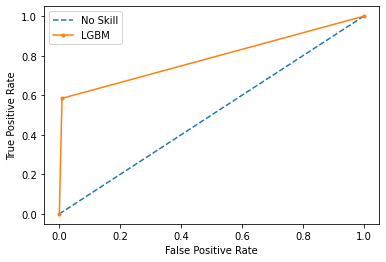

In [130]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, preds)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()